In [3]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, \
multilabel_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import hamming_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
quran_path = '/content/gdrive/MyDrive/TUGAS AKHIR/CODE/data quranverses/quran_multi_label_dataset.csv'
quran = pd.read_csv(quran_path)
quran.head()

,Surah,Ayah,Text,Label
0,1,2,"Praise be to Allah, the Cherisher and Sustaine...",['muslim_ethic']
1,1,3,"Most Gracious, Most Merciful;",['pillars_of_faith']
2,1,4,Master of the Day of Judgment.,['pillars_of_faith']
3,1,6,"Show us the straight way,",['pillars_of_faith']
4,1,7,The way of those on whom Thou hast bestowed Th...,"['pillars_of_faith', 'forbiden_acts']"


In [7]:
df = quran.copy()
df.head()

,Surah,Ayah,Text,Label
0,1,2,"Praise be to Allah, the Cherisher and Sustaine...",['muslim_ethic']
1,1,3,"Most Gracious, Most Merciful;",['pillars_of_faith']
2,1,4,Master of the Day of Judgment.,['pillars_of_faith']
3,1,6,"Show us the straight way,",['pillars_of_faith']
4,1,7,The way of those on whom Thou hast bestowed Th...,"['pillars_of_faith', 'forbiden_acts']"


In [8]:
df.isna().sum()

Surah    0
Ayah     0
Text     0
Label    0
dtype: int64

In [9]:
df = df.dropna()
df.isna().sum()

Surah    0
Ayah     0
Text     0
Label    0
dtype: int64

In [10]:
print(df.shape)

(4054, 4)


In [11]:
df.dtypes

Surah     int64
Ayah      int64
Text     object
Label    object
dtype: object

karena df['Label'] pada dataset dibaca sebagai object/string (bukan list), maka harus diubah ke dalam bentuk list agar dapat dilakukan proses komputasi

In [12]:
labels = list()

for lbl in df['Label']:
    txt = lbl.replace('[','').replace(']','').replace(',', '').replace("'", '').split()
    labels.append(txt)

labels[:5]

[['muslim_ethic'],
 ['pillars_of_faith'],
 ['pillars_of_faith'],
 ['pillars_of_faith'],
 ['pillars_of_faith', 'forbiden_acts']]

Kemudian label diubah ke bentuk one-hot encoding

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

y = pd.DataFrame(mlb.fit_transform(labels),columns=mlb.classes_, index=df.index)

In [14]:
y.head()

,creation_and_creatures,forbiden_acts,foundations_of_the_laws,invocations_in_the_quran,makkah,mandatory_acts,muslim_ethic,people_of_the_book,pillars_of_faith,science_in_the_quran
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,1,0


In [15]:
y.describe()

,creation_and_creatures,forbiden_acts,foundations_of_the_laws,invocations_in_the_quran,makkah,mandatory_acts,muslim_ethic,people_of_the_book,pillars_of_faith,science_in_the_quran
count,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000,4054.000000
mean,0.122595,0.427232,0.093488,0.010853,0.007153,0.115195,0.207943,0.047854,0.596201,0.051554
std,0.328012,0.494738,0.291151,0.103626,0.084285,0.319296,0.405886,0.213484,0.490719,0.221152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
y.dtypes

creation_and_creatures      int64
forbiden_acts               int64
foundations_of_the_laws     int64
invocations_in_the_quran    int64
makkah                      int64
mandatory_acts              int64
muslim_ethic                int64
people_of_the_book          int64
pillars_of_faith            int64
science_in_the_quran        int64
dtype: object

Karena nilai di setiap kolom y adalah integer, maka perlu diubah menjadi float

In [17]:
for col in y.columns:
  y[col] = y[col].astype(float)

In [18]:
y.dtypes

creation_and_creatures      float64
forbiden_acts               float64
foundations_of_the_laws     float64
invocations_in_the_quran    float64
makkah                      float64
mandatory_acts              float64
muslim_ethic                float64
people_of_the_book          float64
pillars_of_faith            float64
science_in_the_quran        float64
dtype: object

In [19]:
y.head()

,creation_and_creatures,forbiden_acts,foundations_of_the_laws,invocations_in_the_quran,makkah,mandatory_acts,muslim_ethic,people_of_the_book,pillars_of_faith,science_in_the_quran
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


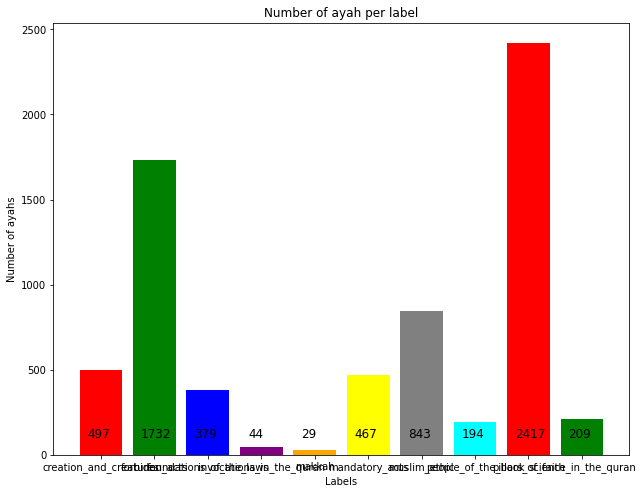

In [20]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
total_count = []
label = y.columns
for lbl in label:
    total_count.append(len(y[y[lbl] == 1]))
ax.bar(label,total_count, color=['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'grey', 'cyan'])
for i,data in enumerate(total_count):
    plt.text(i-.25, 
              data/total_count[i]+100, 
              total_count[i], 
              fontsize=12)
plt.title('Number of ayah per label')
plt.xlabel('Labels')
plt.ylabel('Number of ayahs')

plt.show()

### Preprocessing

#### Text Cleaning

In [21]:
from nltk.corpus import stopwords
nltk.download('stopwords')

punct = [char for char in string.punctuation]
stop = stopwords.words('english')
def clean_text(txt):
    text = txt.lower()
    for pun in punct:
        text = text.replace(pun, '')

    # remove stopwords
    # text = " ".join([word for word in text.split() if word not in (stop)])

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
df['cleaned_text'] = df['Text'].apply(lambda x: clean_text(x))
df_cleaned = df.drop(['Text', 'Label'], axis=1)
df_cleaned.head()

,Surah,Ayah,cleaned_text
0,1,2,praise be to allah the cherisher and sustainer...
1,1,3,most gracious most merciful
2,1,4,master of the day of judgment
3,1,6,show us the straight way
4,1,7,the way of those on whom thou hast bestowed th...


In [23]:
nltk.download('punkt')
tokens = [nltk.word_tokenize(text) for text in df['cleaned_text']]
df['tokens'] = tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [24]:
df_cleaned.head()

,Surah,Ayah,cleaned_text
0,1,2,praise be to allah the cherisher and sustainer...
1,1,3,most gracious most merciful
2,1,4,master of the day of judgment
3,1,6,show us the straight way
4,1,7,the way of those on whom thou hast bestowed th...


In [75]:
df_cleaned.tail(6)

,Surah,Ayah,cleaned_text
4048,112,3,he begetteth not nor is he begotten
4049,113,1,say i seek refuge with the lord of the dawn
4050,113,2,from the mischief of created things
4051,113,4,from the mischief of those who practise secret...
4052,114,2,the king or ruler of mankind
4053,114,5,the same who whispers into the hearts of mankind


### Text Preprocessing with Neat Text

In [25]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 13.0 MB/s 


In [26]:
import neattext as nt
import neattext.functions as nfx

In [27]:
df_cleaned['cleaned_text'].apply(lambda x:nt.TextFrame(x).noise_scan())

0       {'text_noise': 10.0, 'text_length': 60, 'noise...
1       {'text_noise': 7.4074074074074066, 'text_lengt...
2       {'text_noise': 10.344827586206897, 'text_lengt...
3       {'text_noise': 12.5, 'text_length': 24, 'noise...
4       {'text_noise': 12.037037037037036, 'text_lengt...
                              ...                        
4049    {'text_noise': 13.953488372093023, 'text_lengt...
4050    {'text_noise': 8.571428571428571, 'text_length...
4051    {'text_noise': 9.803921568627452, 'text_length...
4052    {'text_noise': 10.714285714285714, 'text_lengt...
4053    {'text_noise': 12.5, 'text_length': 48, 'noise...
Name: cleaned_text, Length: 4054, dtype: object

In [28]:
df_cleaned['cleaned_text'].apply(lambda x:nt.TextExtractor(x).extract_stopwords())

0                             [be, to, the, and, of, the]
1                                            [most, most]
2                                           [of, the, of]
3                                         [show, us, the]
4       [the, of, those, on, whom, those, whose, is, n...
                              ...                        
4049                         [say, i, with, the, of, the]
4050                                      [from, the, of]
4051                          [from, the, of, those, who]
4052                                        [the, or, of]
4053                      [the, same, who, into, the, of]
Name: cleaned_text, Length: 4054, dtype: object

In [29]:
df_cleaned['cleaned_text'].apply(nfx.remove_stopwords)

0                 praise allah cherisher sustainer worlds
1                                       gracious merciful
2                                     master day judgment
3                                            straight way
4       way thou hast bestowed thy grace portion wrath...
                              ...                        
4049                                seek refuge lord dawn
4050                              mischief created things
4051                        mischief practise secret arts
4052                                   king ruler mankind
4053                              whispers hearts mankind
Name: cleaned_text, Length: 4054, dtype: object

In [54]:
annas_corpus = df_cleaned['cleaned_text'].append(annas_text)
corpus = df_cleaned['cleaned_text'].apply(nfx.remove_stopwords)

In [106]:
corpus2 = annas_corpus.apply(nfx.remove_stopwords)
x_annas = tfidf.transform(corpus2).toarray()

In [98]:
x_annas = x_annas[-2:-1]

In [107]:
x_nass = []
for x in range(len(x_annas)):
  if x >= (len(x_annas) - 6):
    x_nass.append(x_annas[x])

In [108]:
len(x_nass)

6

In [59]:
x_annas

array([], shape=(0, 5396), dtype=float64)

In [31]:
tfidf = TfidfVectorizer()

In [77]:
Xfeatures = tfidf.fit_transform(corpus).toarray()

In [33]:
Xfeatures

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
X_train,X_test,y_train,y_test = train_test_split(Xfeatures,y,test_size=0.3,random_state=42)

## Train Model

In [ ]:
def pipeline_nb(alpha):
  hamming = []
  for al in alpha:
    nb_cc = ClassifierChain(MultinomialNB(alpha = al))
    nb_br = BinaryRelevance(MultinomialNB(alpha = al))
    nb_lp = LabelPowerset(MultinomialNB(alpha = al))

    nb_cc.fit(X_train, y_train)
    nb_br.fit(X_train, y_train)
    nb_lp.fit(X_train, y_train) 

    pred1 = nb_cc.predict(X_test)
    pred2 = nb_br.predict(X_test)
    pred3 = nb_lp.predict(X_test)

    print('\nalpha = ', str(al))
    print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
    print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
    print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

    hamming.append(hamming_loss(y_test, pred1))   
    hamming.append(hamming_loss(y_test, pred2))   
    hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

In [ ]:
def pipeline_knn(n_neighbors):
  hamming = []
  for neigh in n_neighbors:
    knn_cc = ClassifierChain(KNeighborsClassifier(n_neighbors=neigh))
    knn_br = BinaryRelevance(KNeighborsClassifier(n_neighbors=neigh))
    knn_lp = LabelPowerset(KNeighborsClassifier(n_neighbors=neigh))

    knn_cc.fit(X_train, y_train)
    knn_br.fit(X_train, y_train)
    knn_lp.fit(X_train, y_train)

    pred1 = knn_cc.predict(X_test)
    pred2 = knn_br.predict(X_test)
    pred3 = knn_lp.predict(X_test)

    print('\nn_neighbors = ', str(neigh))
    print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
    print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
    print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

    hamming.append(hamming_loss(y_test, pred1))   
    hamming.append(hamming_loss(y_test, pred2))   
    hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

In [35]:
def pipeline_svm(kernel, gamma):
  hamming = []
  for ker in kernel:
    for g in gamma :
      svm_cc = ClassifierChain((SVC(kernel=ker, gamma=g)))
      svm_br = BinaryRelevance((SVC(kernel=ker, gamma=g)))
      svm_lp = LabelPowerset((SVC(kernel=ker, gamma=g)))

      svm_cc.fit(X_train, y_train)
      svm_br.fit(X_train, y_train)
      svm_lp.fit(X_train, y_train)

      pred1 = svm_cc.predict(X_test)
      pred2 = svm_br.predict(X_test)
      pred3 = svm_lp.predict(X_test)

      print('\nkernel = %s, gamma = %s' % (str(ker), str(g)))
      print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
      print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
      print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

      hamming.append(hamming_loss(y_test, pred1))   
      hamming.append(hamming_loss(y_test, pred2))   
      hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

In [ ]:
def pipeline_dt(random_state):
  hamming = []
  for ran in random_state:
    dt_cc = ClassifierChain(DecisionTreeClassifier(random_state=ran))
    dt_br = BinaryRelevance(DecisionTreeClassifier(random_state=ran))
    dt_lp = LabelPowerset(DecisionTreeClassifier(random_state=ran))

    dt_cc.fit(X_train, y_train)
    dt_br.fit(X_train, y_train)
    dt_lp.fit(X_train, y_train)

    pred1 = dt_cc.predict(X_test)
    pred2 = dt_br.predict(X_test)
    pred3 = dt_lp.predict(X_test)

    print('\nrandom state = ', str(ran))
    print('hamming loss (Classifier Chain):', hamming_loss(y_test, pred1))
    print('hamming loss (Binary Relevance):', hamming_loss(y_test, pred2))
    print('hamming loss (Label Powerset):', hamming_loss(y_test, pred3))

    hamming.append(hamming_loss(y_test, pred1))   
    hamming.append(hamming_loss(y_test, pred2))   
    hamming.append(hamming_loss(y_test, pred3))

  print('')   
  print('BEST : ', min(hamming))

**Naive Bayes**

In [ ]:
alpha = [0.1, 1.0, 10, 100]

pipeline_nb(alpha)


alpha =  0.1
hamming loss (Classifier Chain): 0.12522596548890716
hamming loss (Binary Relevance): 0.12703368940016435
hamming loss (Label Powerset): 0.13212818405916188

alpha =  1.0
hamming loss (Classifier Chain): 0.12966310599835662
hamming loss (Binary Relevance): 0.13155299917830732
hamming loss (Label Powerset): 0.14264585045193098

alpha =  10
hamming loss (Classifier Chain): 0.1474116680361545
hamming loss (Binary Relevance): 0.147658175842235
hamming loss (Label Powerset): 0.15053410024650782

alpha =  100
hamming loss (Classifier Chain): 0.15053410024650782
hamming loss (Binary Relevance): 0.15053410024650782
hamming loss (Label Powerset): 0.15053410024650782

BEST :  0.12522596548890716


**KNN**

In [ ]:
n_neighbors = [8, 10, 20, 64]

pipeline_knn(n_neighbors)


n_neighbors =  8
hamming loss (Classifier Chain): 0.13270336894001644
hamming loss (Binary Relevance): 0.1306491372226787
hamming loss (Label Powerset): 0.1341824157764996

n_neighbors =  10
hamming loss (Classifier Chain): 0.13097781429745275
hamming loss (Binary Relevance): 0.128759244042728
hamming loss (Label Powerset): 0.13163516844700082

n_neighbors =  20
hamming loss (Classifier Chain): 0.1304847986852917
hamming loss (Binary Relevance): 0.12990961380443714
hamming loss (Label Powerset): 0.13204601479046837

n_neighbors =  64
hamming loss (Classifier Chain): 0.1306491372226787
hamming loss (Binary Relevance): 0.1303204601479047
hamming loss (Label Powerset): 0.13681183237469186

BEST :  0.128759244042728


**SVM**

In [ ]:
kernel = ["rbf", "linear"]
gamma = [0.1, "auto", "scale"]

pipeline_svm(kernel, gamma)


kernel = rbf, gamma = 0.1
hamming loss (Classifier Chain): 0.1409202958093673
hamming loss (Binary Relevance): 0.14215283483976993
hamming loss (Label Powerset): 0.14987674609695975

kernel = rbf, gamma = auto
hamming loss (Classifier Chain): 0.15053410024650782
hamming loss (Binary Relevance): 0.15053410024650782
hamming loss (Label Powerset): 0.15053410024650782

kernel = rbf, gamma = scale
hamming loss (Classifier Chain): 0.1267871815940838
hamming loss (Binary Relevance): 0.11922760887428102
hamming loss (Label Powerset): 0.13820870994248152

kernel = linear, gamma = 0.1
hamming loss (Classifier Chain): 0.11413311421528348
hamming loss (Binary Relevance): 0.11101068200493015
hamming loss (Label Powerset): 0.1305669679539852

kernel = linear, gamma = auto
hamming loss (Classifier Chain): 0.11413311421528348
hamming loss (Binary Relevance): 0.11101068200493015
hamming loss (Label Powerset): 0.1305669679539852

kernel = linear, gamma = scale
hamming loss (Classifier Chain): 0.1141331

In [45]:
svm_br = BinaryRelevance((SVC(kernel="linear", gamma="scale")))
svm_br.fit(X_train,y_train)

BinaryRelevance(classifier=SVC(kernel='linear'), require_dense=[True, True])

In [37]:
annas = pd.read_csv('/content/gdrive/MyDrive/TUGAS AKHIR/CODE/Quranic Topic Classification/en.yusufali.csv')
annas = annas.tail(6)

In [40]:
annas_text = annas['Text'].apply(lambda x: clean_text(x))

In [41]:
annas_text.apply(lambda x:nt.TextFrame(x).noise_scan())

6230    {'text_noise': 10.714285714285714, 'text_lengt...
6231    {'text_noise': 10.714285714285714, 'text_lengt...
6232    {'text_noise': 11.11111111111111, 'text_length...
6233    {'text_noise': 10.81081081081081, 'text_length...
6234    {'text_noise': 12.5, 'text_length': 48, 'noise...
6235    {'text_noise': 12.0, 'text_length': 25, 'noise...
Name: Text, dtype: object

In [42]:
annas_text.apply(lambda x:nt.TextExtractor(x).extract_stopwords())

6230                 [say, i, with, the, and, of]
6231                                [the, or, of]
6232                                [the, or, of]
6233    [from, the, of, the, of, who, after, his]
6234              [the, same, who, into, the, of]
6235                          [among, and, among]
Name: Text, dtype: object

In [43]:
annas_text.apply(nfx.remove_stopwords)

6230           seek refuge lord cherisher mankind
6231                           king ruler mankind
6232                            god judge mankind
6233    mischief whisperer evil withdraws whisper
6234                      whispers hearts mankind
6235                                    jinns men
Name: Text, dtype: object

In [51]:
annas_corpus = annas_text.apply(nfx.remove_stopwords)
x_annas = tfidf.fit_transform(annas_corpus)

In [109]:
label_annas = svm_br.predict(x_nass).toarray()

In [110]:
print(label_annas)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [113]:
y.columns

Index(['creation_and_creatures', 'forbiden_acts', 'foundations_of_the_laws',
       'invocations_in_the_quran', 'makkah', 'mandatory_acts', 'muslim_ethic',
       'people_of_the_book', 'pillars_of_faith', 'science_in_the_quran'],
      dtype='object')

In [50]:
pd.DataFrame(label_annas)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4050,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4051,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Decision Tree**

In [ ]:
random_state = [0, None]

pipeline_dt(random_state)


random state =  0
hamming loss (Classifier Chain): 0.13837304847986853
hamming loss (Binary Relevance): 0.13303204601479046
hamming loss (Label Powerset): 0.1656532456861134

random state =  None
hamming loss (Classifier Chain): 0.13459326211996714
hamming loss (Binary Relevance): 0.1325390304026294
hamming loss (Label Powerset): 0.16211996713229251

BEST :  0.1325390304026294
